# **Lab Session : Feature selection II**

Author: Vanessa Gómez Verdejo (http://vanessa.webs.tsc.uc3m.es/)

Updated: 19/04/2017 (working with sklearn 0.18.1)

Here, we will continue with work of the notebook Feature Selection I, and we will focus on wrapper and embedded feature selection methods. To analyze their performances we will continue working with the Olivetti face detection problem. 

#### ** During this lab we will cover: **
#### *Part 1: Wrapers for feature selection: RFE* 
#### *Part 2: Embedded methods: L1 regularization*

In [1]:
%matplotlib inline

## ** Part 0.1: Download and prepare the data **

Olivetti dataset consists of ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).
    
The next code includes the lines to download this data set and create the training, validation and test data partitions, as well as normalize them.

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_olivetti_faces 
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
print 'The first time that you downlaod the data it can take a while...'
olivetti_people = fetch_olivetti_faces()

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = olivetti_people.images.shape

# for machine learning we use the data directly (as relative pixel
# positions info is ignored by this model)
X = olivetti_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
Y = olivetti_people.target
n_classes = np.unique(Y).shape[0]

print("Dataset size information:")
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


###############################################################################
# Preparing the data

# Initialize the random generator seed to compare results
np.random.seed(1)

# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

# split into a training and validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.333)

# Normalizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Binarize the labels for some feature selection methods
set_classes = np.unique(Y)
Y_train_bin = label_binarize(Y_train, classes=set_classes)

print("Number of training samples: %d" % X_train.shape[0])
print("Number of validation samples: %d" % X_val.shape[0])
print("Number of test samples: %d" % X_test.shape[0])

The first time that you downlaod the data it can take a while...
downloading Olivetti faces from http://cs.nyu.edu/~roweis/data/olivettifaces.mat to C:\Users\Javi\scikit_learn_data
Dataset size information:
n_features: 4096
n_classes: 40
Number of training samples: 200
Number of validation samples: 100
Number of test samples: 100


## ** Part 0.2: Some utilities **

Here, you can find some functions from the notebook Feature Selection I which can be usefull for completing the following sections.

In [3]:
from sklearn import svm

def SVM_accuracy_evolution(X_train_s, Y_train, X_val_s, Y_val, X_test_s, Y_test, rang_feat):
    """Compute the accuracy of training, validation and test data for different the number of features given
        in rang_feat.

    Args:
        X_train_s (numpy dnarray): training data sorted by relevance (more relevant are first) (number data x number dimensions).
        Y_train (numpy dnarray): labels of the training data (number data x 1).
        X_val_s (numpy dnarray): validation data sorted by relevance (more relevant are first) (number data x number dimensions).
        Y_val (numpy dnarray): labels of the validation data (number data x 1).
        X_test_s (numpy dnarray): test data sorted by relevance (more relevant are first) (number data x number dimensions).
        Y_test (numpy dnarray): labels of the test data (number data x 1).
        rang_feat: range with different number of features to be evaluated                                           
   
    """
    
    # Define the model to train a liner SVM and adjust by CV the parameter C
    clf = svm.SVC(kernel='linear')
    acc_tr = []
    acc_val = []
    acc_test = []
    for i in rang_feat:
        # Train SVM classifier
        clf.fit(X_train_s[:, :i], Y_train)
        # Compute accuracies
        acc_tr.append(clf.score(X_train_s[:, :i], Y_train))
        acc_val.append(clf.score(X_val_s[:, :i], Y_val))
        acc_test.append(clf.score(X_test_s[:, :i], Y_test))

    return np.array(acc_tr), np.array(acc_val), np.array(acc_test)


In [4]:
import matplotlib.pyplot as plt

def plot_accuracy_evolution(rang_feat, acc_tr, acc_val, acc_test):

    """Plot the accuracy evolution for training, validation and test data sets.
    Args:
        rang_feat: range with different number of features where the accuracy has been evaluated   
        acc_tr: numpy vector with the training accuracies
        acc_val: numpy vector with the validation accuracies
        acc_test: numpy vector with the test accuracies                                          
    """

    plt.plot(rang_feat, acc_tr, "b", label="train")
    plt.plot(rang_feat, acc_val, "g", label="validation")
    plt.plot(rang_feat, acc_test, "r", label="test")
    plt.xlabel("Number of features")
    plt.ylabel("Accuracy")
    plt.title('Accuracy evolution')
    plt.legend(['Training', 'Validation', 'Test'], loc = 4)


In [5]:
import matplotlib.pyplot as plt
def plot_image(image, h, w):
    """Helper function to plot a face image
    Args:
        image: numpy vector with the image to plot (of dimensions h*w)
        h: height of the image (in number of pixels)
        w: width of the image (in number of pixels)  """  
    
    plt.imshow(image.reshape((h, w)), cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())
    plt.colorbar()

# Part 1: Wrapers for feature selection: RFE

The Recursive Feature Elimination (RFE) method iteratively trains a set of SVM classifier and, in each step, it eliminates a feature (or a subset of features) in such a way that the classification margin is reduced the least.

Scikit-Learn provides a function with a full implementation of the RFE method. This function, [RFE( )](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html), let user select the classifier to consider, the number of selected features (parameter n\_features\_to\_select) and the number of features removed in each step (parameter step).  As result, in parameter .ranking returns the ranking position of the each feature (i.e., .ranking\_[i] corresponds to the ranking position of the i-th feature).

Complete the following code to:
* Train the RFE approach with a linear SVM fixing  n_features_to_select to 10 (so that we run the RFE method until the end obtaining a full raking with all the features) and step to 10 (just to speed up the training).
* Use the content of .ranking\_ to obtain a ranking with the most relevant features, save their positions in the variable  ind\_rel\_feat.


In [6]:
###########################################################
# TODO: Replace <FILL IN> with appropriate code
###########################################################
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

print 'The training of this method can take some minutes, be patient...'
# Define the classifier, the RFE method and train it
estimator = SVC(kernel="linear")
RFE_selector = RFE(estimator,n_features_to_select=10, step=10)
RFE_selector.fit(X_train, Y_train)

# Obtain the positions of the sorted features (the most relevant first)
ind_rel_feat = np.argsort(RFE_selector.ranking_)

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d" % (f + 1, ind_rel_feat[f]))

The training of this method can take some minutes, be patient...
Feature ranking:
1. feature 781
2. feature 3615
3. feature 648
4. feature 1016
5. feature 51
6. feature 1555
7. feature 566
8. feature 4061
9. feature 2268
10. feature 4049


In [7]:
###########################################################
# TEST CELL
###########################################################

from test_helper import Test

# TEST Training and test data generation
Test.assertEquals(np.sum(ind_rel_feat[:5]- [781, 3615, 648,  1016, 51]),0, 'incorrect result: first positions of relevant features are uncorrect')

ImportError: No module named test_helper

As in the random forest section, use the above the result to:
* Evaluate the linear SVM performance with the most relevant features are used (use SVM_accuracy_evolution( ) function). Plot the evolution of the training, validation and test accuracies.
* Obtain, using the validation accuracy, the optimum number of features to use.
* Create the mask with the selected features and plot it (you can use the plot_image( ) function).

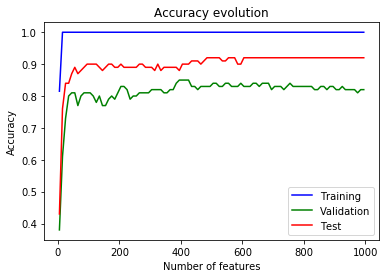

Number optimum of features: 395
The optimum test accuracy is  88.00%


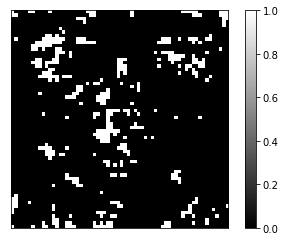

In [9]:
###########################################################
# TODO: Replace <FILL IN> with appropriate code
###########################################################
# Define the range of features to explore
# (explore the 1000 most relevant ones, starting with 5 and usings steps of 10 features)
rang_feat = np.arange(5, 1000, 10) # To speed up the execution, we use steps of 10 features.
X_train_s = X_train[:,ind_rel_feat]
X_val_s = X_val[:,ind_rel_feat]
X_test_s = X_test[:,ind_rel_feat]
[acc_tr, acc_val, acc_test] = SVM_accuracy_evolution(X_train_s, Y_train, X_val_s, Y_val, X_test_s, Y_test, rang_feat)

# Plot it!
plt.figure()
plot_accuracy_evolution(rang_feat, acc_tr, acc_val, acc_test)
plt.show()

# Find the optimum number of features
pos_max = np.argmax(acc_val)
num_opt_feat = rang_feat[pos_max]
test_acc_opt = acc_test[pos_max]

print 'Number optimum of features: ' + str(num_opt_feat)
print("The optimum test accuracy is  %2.2f%%" %(100*test_acc_opt))

# Create and plot the mask
mask = np.zeros([h*w])
mask[ind_rel_feat[0:num_opt_feat]] = 1
plt.figure()
plot_image(mask, h, w)
plt.show()

In [10]:
###########################################################
# TEST CELL
###########################################################

from test_helper import Test

# TEST Training and test data generation
Test.assertEquals(num_opt_feat,395, 'incorrect result: number of selected features is uncorrect')
Test.assertEquals(test_acc_opt,0.88, 'incorrect result: test error is uncorrect')

ImportError: No module named test_helper

## ** Part 2: Embedded methods:  L1 regularization**

Embedded methods are able to carry out the feature selection process during the classifier training, so both stages (feature selection and classifier training) are completely linked and, therefore, the selection process is guided by the classifier.

In this case, we are going to study two well-known techniques:  
* L1 SVM: in this case we can train linear SVM regularized with a L1 penalty which is able to provide sparsity over the weight vector. As to obtain the classifier output we have to multiply the input data by this vector, those input features associated to the zeros of the weight vector are not used during the classification process (at least, in binary problem, we later analyze this in detail for the multiclass case). 

* L1 Logistic Regression: here, we will apply the above L1 penalty, but using a Logistic Regression classifier.

### ** Part 2.1: L1-SVM**

In this last section, we are going to analyze the properties of the L1-SVM as feature selection approach. For this purpose, we are going to use the linear SVM implementation given by the method LinearSVC, which directly let us select the regularization to be used.

Unlike previous methods, here we cannot obtain a ranking of variables. In this case, we have to sweep the value of the regularization parameter in order to get a higher (or lower) sparsity of the weight vector. According to this, complete the following code to:
* Train a linear l1-SVM for different values of the regularization parameter, for each value obtain the training, validation and test accuracies, as well as the sparsity rate. Sparsity Rate (SR) is defined as the mean number of zeros of the SVM weight vector (check the parameter .coef\_ of the SVM classifier), then, if all elements are zero, SR has to be 100%.
* Plot the resulting accuracy curves.
* Finally, analyzing the validation accuracy, select the optimum value of C.

Note:  As we are working with a multiclass problem (1 vs all scheme), we are going to obtain a set of vectors (one for each binary problem). We could define different approaches to work with this set of vectors, however, for the sake of simplicity, in this first exercise, let's compute the multiclass SR by averaging the SR of each vector.

The training of this method can take some minutes, be patient...


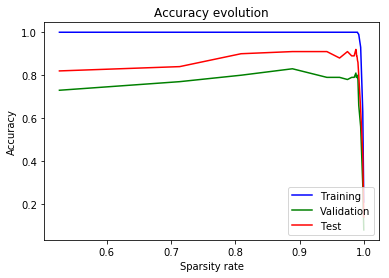

Optimum value of C: 324.755347838
The optimum test accuracy is  91.00%


In [11]:
###########################################################
# TODO: Replace <FILL IN> with appropriate code
###########################################################
from sklearn.svm import LinearSVC
np.random.seed(1)
# Defining some useful variables to save results
acc_tr = []
acc_val = []
acc_test = []
sparsity_rate = []

# Defining the range of C values to explore
rang_C = 2*np.logspace(-2, 3, 20)

print 'The training of this method can take some minutes, be patient...'
for i, C in enumerate(rang_C):
    # Define and train SVM classifier
    svm_l1 = LinearSVC(C=C, penalty="l1", dual=False)
    svm_l1.fit(X_train, Y_train)
    
    # Compute the sparsity rate (coef_l1 contains zeros due to the
    # L1 sparsity inducing norm)
    aux = np.sum(svm_l1.coef_.ravel()==0)
    sparsity_rate.append(float(aux)/(svm_l1.coef_.shape[0]*svm_l1.coef_.shape[1]))
    
    # Compute accuracies
    acc_tr.append(svm_l1.score(X_train, Y_train))
    acc_val.append(svm_l1.score(X_val, Y_val))
    acc_test.append(svm_l1.score(X_test, Y_test))

    
# Plot the accuracy curves
plt.figure()
plot_accuracy_evolution(sparsity_rate, acc_tr, acc_val, acc_test)
plt.xlabel("Sparsity rate")
plt.show()

# Find the optimum value of C
index = np.argmax(acc_val)
C_opt = rang_C[index]
test_acc_opt = acc_test[index]

print 'Optimum value of C: ' + str(C_opt)
print("The optimum test accuracy is  %2.2f%%" %(100*test_acc_opt))


In [13]:
###########################################################
# TEST CELL
###########################################################
print np.round(C_opt,2)
print test_acc_opt
from test_helper import Test

# TEST Training and test data generation
Test.assertEquals(np.round(C_opt,2), 2.07, 'incorrect result: the selected value of C is uncorrect')
Test.assertEquals(test_acc_opt,0.9, 'incorrect result: test error is uncorrect')

324.76
0.91


ImportError: No module named test_helper

Until now, the L1-SVM has provided a sparsity vector instead of a real feature selection. Note that, as we are working in a multiclass problem, we have as many vectors as categories (we are training a 1 vs. all classifier) and each vector has the zeros in different positions, so each classifier is using different input features. So, we obtain a feature selection per categories.

To analyze this selection per categories, you can run the following code which will train again the L1-SVM with optimum value of the C that we have just selected. Then, it will let you get the set of weight vectors and generate a set of masks with the selected variables for each class. Finally, plot all these masks.

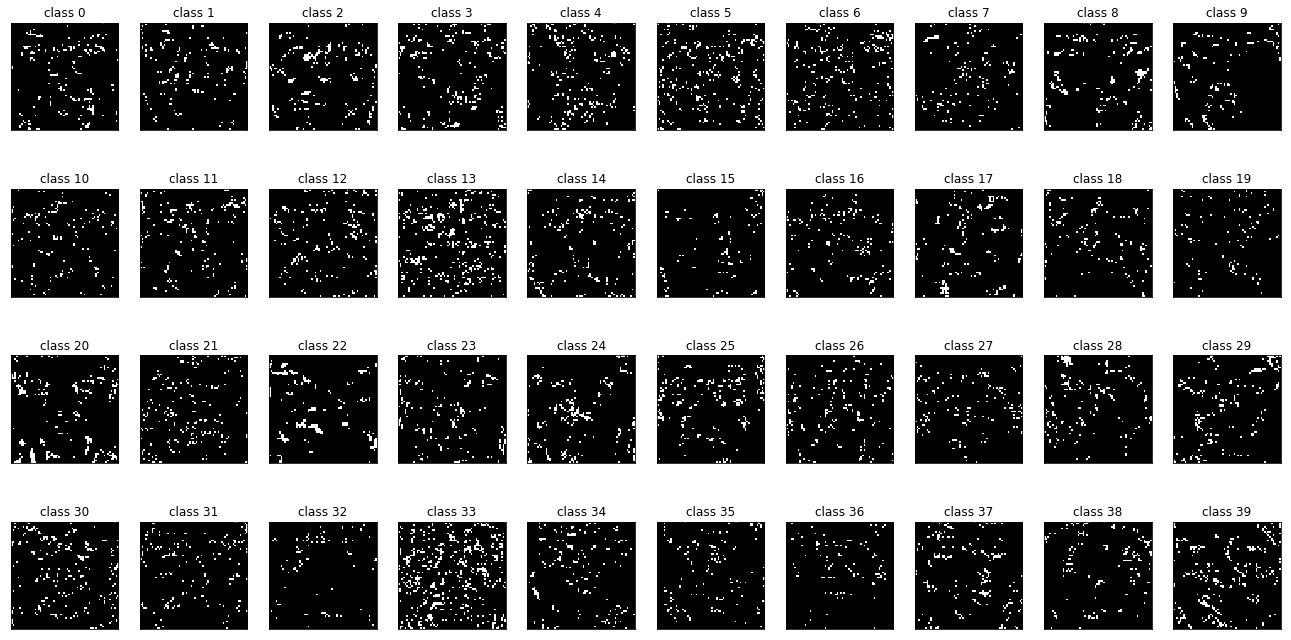

In [14]:
# Train the linear SVM with the optimum value of C
svm_l1 = LinearSVC(C=C_opt, penalty="l1", dual=False)
svm_l1.fit(X_train, Y_train)
coef_l1 = svm_l1.coef_
coef_l1.shape

#### Useful function for display purposes ##########
import matplotlib.pyplot as plt
def plot_gallery(images, titles, h, w, n_row=4, n_col=10):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(images.shape[0]):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
##################################################### 

# Create a mask per class
mask_class = np.zeros(coef_l1.shape)
mask_class [np.where(coef_l1>0)] = 1

# Plot all the masks
titles = ['class '+str(c) for c in set_classes]
plot_gallery(mask_class, titles, h, w)
plt.show()


Finally, we can convert this feature selection per class in a real feature selection. For this purpose, we just have to select all the input features which are used in at least one individual classifier. 
Compete the following code to be able to:
* Find the selected features (those used by at least one individual classifier). 
* Save in num\_var\_sel the number of selected features.
* Train a linear SVM with these features and compute its test accuracy.
* Plot the mask of selected features

If we define the feature relevance as the number of classifiers that use that feature, could you obtain a mask of feature relevances?  

Number optimum of features: (1L, 3560L)
The test accuracy with real feature selection is  89.00%


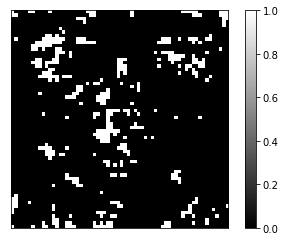

In [26]:
###########################################################
# TODO: Replace <FILL IN> with appropriate code
###########################################################
from sklearn import svm

# Finding the selected fatures
ind_var_sel = np.where(sum(mask_class)>0) # <FILL IN>

# Save the number of selected features
num_var_sel = np.shape(ind_var_sel)# <FILL IN>

# Evaluating performance (for comparison purposes, let's use SVC classifier)
clf = svm.SVC(kernel='linear')
clf.fit(X_train, Y_train)
acc_test = clf.score(X_test, Y_test)# <FILL IN>

print 'Number optimum of features: ' + str(num_var_sel )
print("The test accuracy with real feature selection is  %2.2f%%" %(100*acc_test))

# Obtain and plot the mask
mask = np.zeros([h*w])
mask[ind_rel_feat[0:num_opt_feat]] = 1
#mask = # <FILL IN>
plot_image(mask, h, w)
plt.show()
    
#Plot a relevance mask
# <FILL IN>

### ** Part 2.2: L1-Logistic Regression**

The Scikit-Learn Logistic Regression implementation lets us add an L1 regularization to obtain sparsity over the weigths vector, see its help:

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

So, using the L1-SVM code as reference, repeat the Part 2.1 of this Notebook using the L1-Logistic Regression implementation as classifier and feature selector.

The training of this method can take some minutes, be patient...


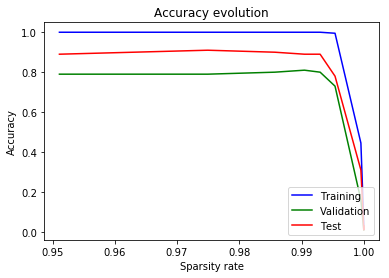

Optimum value of C: 10.0
The optimum test accuracy is  89.00%


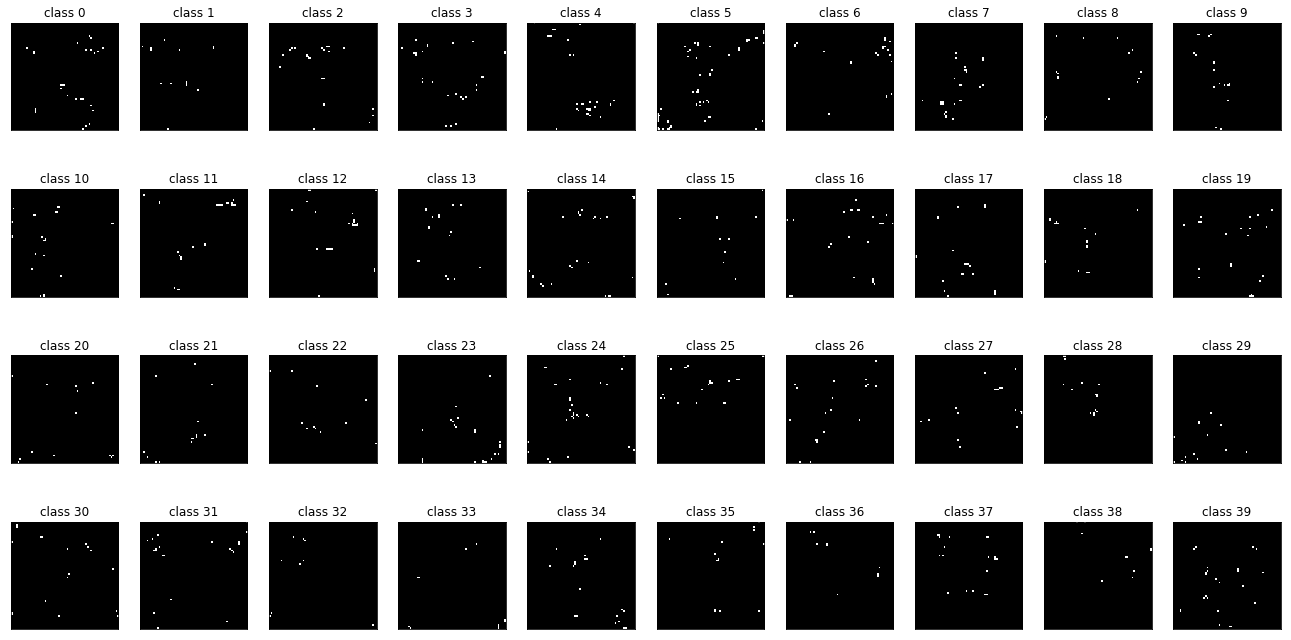

Number optimum of features: (1L, 700L)


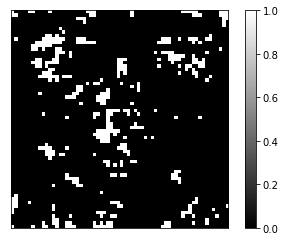

In [27]:
###########################################################
# TODO: Replace <FILL IN> with appropriate code
###########################################################


from sklearn.linear_model import LogisticRegression
np.random.seed(1)
# Defining some useful variables to save results
acc_tr = []
acc_val = []
acc_test = []
sparsity_rate = []



# Defining the range of C values to explore
rang_C = np.logspace(-3, 3, 10)

print 'The training of this method can take some minutes, be patient...'
for i, C in enumerate(rang_C):
    
    
    
    
    # Define and train SVM classifier
    
    lr_l1 = LogisticRegression(C=C, penalty="l1", dual=False)
    lr_l1.fit(X_train, Y_train)
    
    # Compute the sparsity rate (coef_l1 contains zeros due to the
    # L1 sparsity inducing norm)
    aux = np.sum(lr_l1.coef_.ravel()==0)
    sparsity_rate.append(float(aux)/(lr_l1.coef_.shape[0]*lr_l1.coef_.shape[1]))
    
    # Compute accuracies
    acc_tr.append(lr_l1.score(X_train, Y_train))
    acc_val.append(lr_l1.score(X_val, Y_val))
    acc_test.append(lr_l1.score(X_test, Y_test))

    
# Plot the accuracy curves
plt.figure()
plot_accuracy_evolution(sparsity_rate, acc_tr, acc_val, acc_test)
plt.xlabel("Sparsity rate")
plt.show()

# Find the optimum value of C
index = np.argmax(acc_val)
C_opt = rang_C[index]
test_acc_opt = acc_test[index]

print 'Optimum value of C: ' + str(C_opt)
print("The optimum test accuracy is  %2.2f%%" %(100*test_acc_opt))






# Train the linear SVM with the optimum value of C
lr_l1 = LogisticRegression(C=C_opt, penalty="l1", dual=False)
lr_l1.fit(X_train, Y_train)
coef_l1 = lr_l1.coef_
coef_l1.shape

#### Useful function for display purposes ##########
import matplotlib.pyplot as plt
def plot_gallery(images, titles, h, w, n_row=4, n_col=10):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(images.shape[0]):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
##################################################### 

# Create a mask per class
mask_class = np.zeros(coef_l1.shape)
mask_class [np.where(coef_l1>0)] = 1

# Plot all the masks
titles = ['class '+str(c) for c in set_classes]
plot_gallery(mask_class, titles, h, w)
plt.show()








###########################################################
# TODO: Replace <FILL IN> with appropriate code
###########################################################


# Finding the selected fatures
ind_var_sel = np.where(sum(mask_class)>0) # <FILL IN>

# Save the number of selected features
num_var_sel = np.shape(ind_var_sel)# <FILL IN>

# Evaluating performance (for comparison purposes, let's use SVC classifier)
# clf = svm.SVC(kernel='linear')
# clf.fit(X_train, Y_train)
# acc_test = clf.score(X_test, Y_test)# <FILL IN>

print 'Number optimum of features: ' + str(num_var_sel )
# print("The test accuracy with real feature selection is  %2.2f%%" %(100*acc_test))

# Obtain and plot the mask
mask = np.zeros([h*w])
mask[ind_rel_feat[0:num_opt_feat]] = 1

plot_image(mask, h, w)
plt.show()
    
#Plot a relevance mask
# <FILL IN>